In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import os
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from functools import partial
from copy import deepcopy

path = os.path.dirname(os.getcwd())
os.chdir(path)

from src.BayesIMP import *
from src.causalKLGP import *
from src.kernels import *
from src.GP_utils import *
from src.training_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [2]:
# DGP set up
torch.random.manual_seed(1)
d = 5
train_samples = 300
test_samples = 1000
noise_variance = 0.5
input_distribution = torch.distributions.uniform.Uniform(0,1)
mc_samples_EY = 10**4

# PLotting settings
z_val = 1.96

/tmp/ipykernel_376800/2512539941.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724888750493/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  VdoA = (f_x(doA,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T


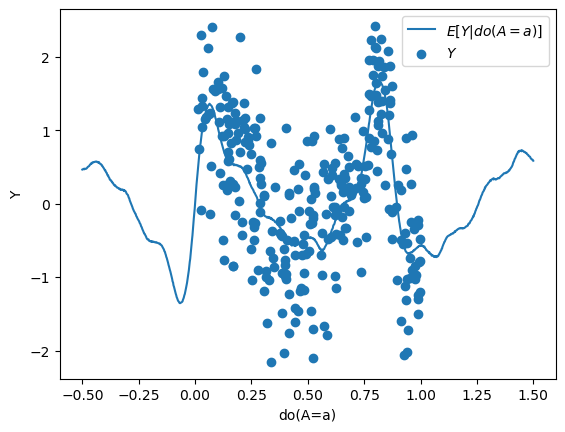

In [3]:
# Dataset generation and plotting E[Y|do(A)]
torch.random.manual_seed(1)
coefs_v = 10*torch.linspace(1,4,d).view(1,d)
coefs_y = 1/torch.linspace(1,d,d).view(d,)

A = input_distribution.sample((train_samples,1))
doA = torch.linspace(-0.5,1.5,test_samples).view(test_samples,1)
fv = f_x(A,coefs_v)#*A
noise_distribution = Normal(0,(noise_variance*fv.var(0))**0.5)
V = fv+noise_distribution.sample((train_samples,))
fy = f_y(V,coefs_y)#*V[:,0]
Y = Normal(fy,(noise_variance*fy.var())**0.5).sample()

# Grid-points to approximate true E[Y|do(A)]
VdoA = (f_x(doA,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T
EYdoA = (f_y(VdoA.T,coefs_y)).mean(1).view(test_samples,1)
YdoA = Normal(f_y(VdoA[...,0].T,coefs_y),(noise_variance*fy.var())**0.5).sample()

# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

### Running BayesIMP

In [4]:
"""Initialising model"""
model = BayesIMP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5,
                   exact = True)

learn_rate = 0.1
niter = 500

""" Training full model """
model.train(Y,A,V,niter,learn_rate, optimise_measure = False, mc_samples = 1000)

RuntimeError: The size of tensor a (300) must match the size of tensor b (5) at non-singleton dimension 1

In [ ]:
# Getting posterior moments and plotting results


fig,axs = plt.subplots(1,2,figsize = (18,5))

Bayesimp_mu = []
Bayesimp_var = []
Bayesimp_var_noise = []
k = 0
    
# getting post mean predictions
Bayesimp = deepcopy(model)
bayesimp_mu = Bayesimp.post_mean(Y, A, V, doA).detach()
bayesimp_var = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = True).detach()
bayesimp_var_noise = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = False).detach()

# Getting CI
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
Upper = (bayesimp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(bayesimp_var[indices])))
Lower = (bayesimp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(bayesimp_var[indices])))
Upper_noise = (bayesimp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(bayesimp_var_noise[indices])))
Lower_noise = (bayesimp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(bayesimp_var_noise[indices])))

axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
axs[k].plot(doA[indices],bayesimp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
#axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
#axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
axs[k].scatter(A,Y, s = 10, color = "black")
axs[k].set_xlabel("do(A)")
axs[k].set_ylabel("Y")
axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")

Bayesimp_mu.append(bayesimp_mu)
Bayesimp_var.append(bayesimp_var.diag())
Bayesimp_var_noise.append(bayesimp_var_noise.diag())

plt.legend()
plt.show()

# causalKLGP

In [4]:
"""Initialising model"""
model = causalKLGP(Kernel_A = GammaExponentialKernel, 
                   Kernel_V = GammaExponentialKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.1,0.3,0.5,0.7,0.9])

Post_levels, Calibration_losses = model.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate, 
                                                  calibrate_latent = True, calibrate_norm = 2)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0][0]
nu_best = nulist[best_ind]
print(Calibration_losses)

iter 0 P(Y|V) loss:  tensor(145.1541)
iter 100 P(Y|V) loss:  tensor(133.1205)
iter 200 P(Y|V) loss:  tensor(132.8199)
iter 300 P(Y|V) loss:  tensor(132.7101)
iter 400 P(Y|V) loss:  tensor(132.6568)
iter 0 P(V|A) loss:  tensor(-79.8554)
iter 100 P(V|A) loss:  tensor(-80.6276)
iter 200 P(V|A) loss:  tensor(-80.6276)
iter 300 P(V|A) loss:  tensor(-80.6276)
iter 400 P(V|A) loss:  tensor(-80.6276)
tensor([0.1067, 0.0621, 0.0647, 0.0498, 0.0453, 0.0462, 0.0365, 0.0444, 0.0533,
        0.0725, 0.0769])


In [5]:
""" Training full model """
model.train(Y,A,V,niter,learn_rate)

iter 0 P(Y|V) loss:  tensor(263.7020)
iter 100 P(Y|V) loss:  tensor(259.9839)
iter 200 P(Y|V) loss:  tensor(259.9476)
iter 300 P(Y|V) loss:  tensor(259.9454)
iter 400 P(Y|V) loss:  tensor(259.9449)
iter 0 P(V|A) loss:  tensor(-591.8380)
iter 100 P(V|A) loss:  tensor(-666.9512)
iter 200 P(V|A) loss:  tensor(-666.9514)
iter 300 P(V|A) loss:  tensor(-666.9513)
iter 400 P(V|A) loss:  tensor(-666.9512)


nu =  tensor(0.2500)
nu =  tensor(1.)
nu =  tensor(4.)


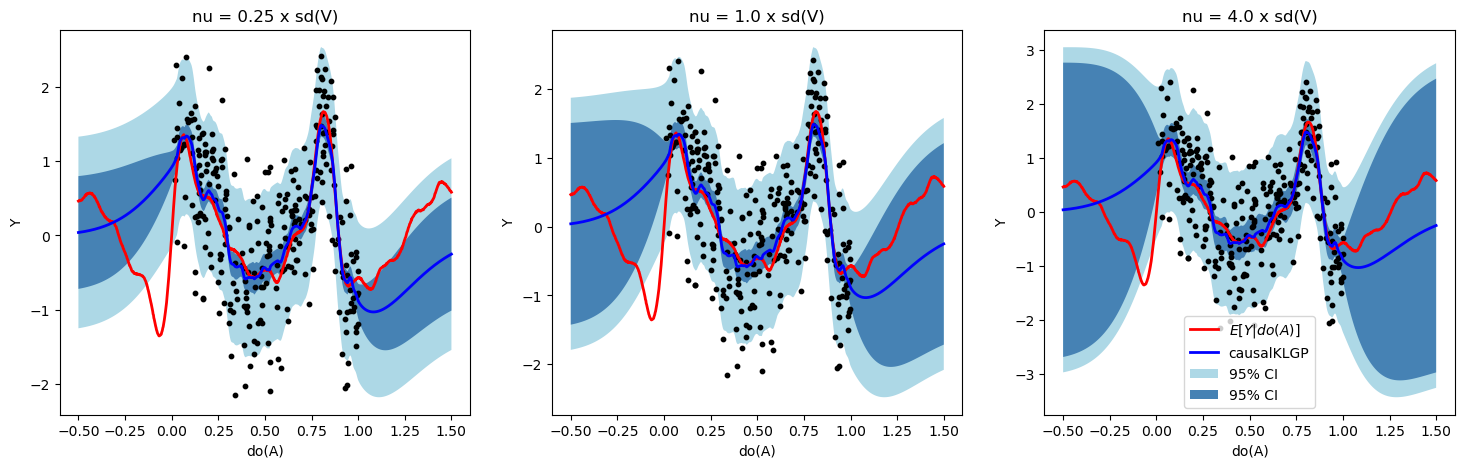

In [6]:
# Getting posterior moments and plotting results
power_list = torch.linspace(-2,2,3)
nulist = 2**power_list

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

Causalklgp_mu = []
Causalklgp_var = []
Causalklgp_var_noise = []

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model)
    causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
    causalklgp_var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach()
    causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (causalklgp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(causalklgp_var[indices])))
    Lower = (causalklgp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(causalklgp_var[indices])))
    Upper_noise = (causalklgp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(causalklgp_var_noise[indices])))
    Lower_noise = (causalklgp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(causalklgp_var_noise[indices])))
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],causalklgp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    
    Causalklgp_mu.append(causalklgp_mu)
    Causalklgp_var.append(causalklgp_var.diag())
    Causalklgp_var_noise.append(causalklgp_var_noise.diag())

plt.legend()
plt.show()

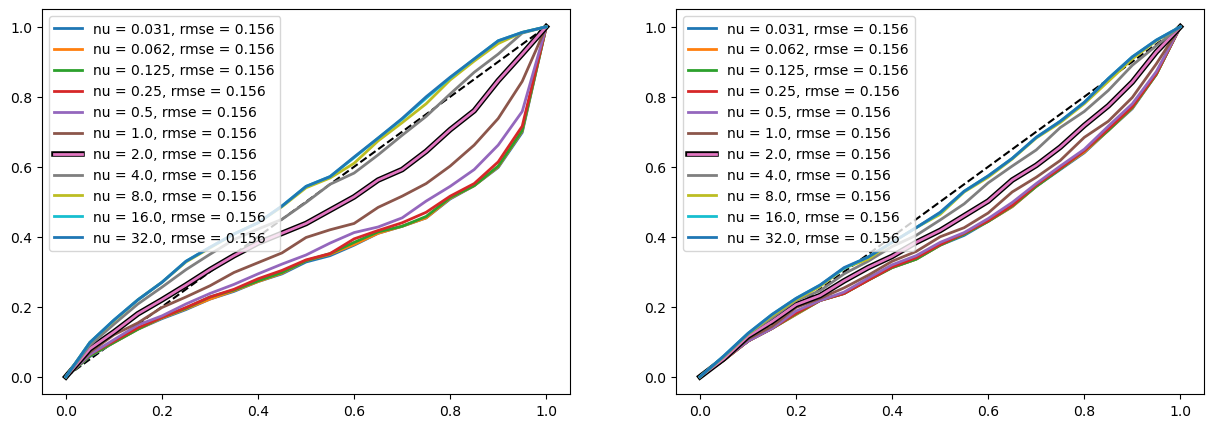

In [7]:
# Getting calibration plots
outline=mpe.withStroke(linewidth=4, foreground='black')
def _round(x, n):
    return int(x*10**n)/10**n

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)[:,None]
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post mean predictions
    mean = causalklgp.post_mean(Y, A, V, doA).detach()
    var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach().diag()[:,None]
    var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach().diag()[:,None]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EYdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)
    posterior_fraction_y = ((YdoA[inds,None] - mean[inds]).abs() <= var_noise[inds]**0.5 @ z_quantiles.T).float().mean(0)
    rmse = ((EYdoA[inds] - mean[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()

# Nystrom method

In [8]:
"""Initialising model"""
model_nystrom = causalKLGP(Kernel_A = GammaExponentialKernel, 
                   Kernel_V = GammaExponentialKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.5,0.75,0.9,0.95])

Post_levels, Calibration_losses = model_nystrom.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate, 
                                                          nystrom = True, nystrom_features = 100, nystrom_samples = 10**3)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0]
nu_best = nulist[best_ind]
print(Calibration_losses)

iter 0 P(Y|V) loss:  tensor(145.1541)
iter 100 P(Y|V) loss:  tensor(133.1205)
iter 200 P(Y|V) loss:  tensor(132.8199)
iter 300 P(Y|V) loss:  tensor(132.7101)
iter 400 P(Y|V) loss:  tensor(132.6568)
iter 0 P(V|A) loss:  tensor(-79.8554)
iter 100 P(V|A) loss:  tensor(-80.6276)
iter 200 P(V|A) loss:  tensor(-80.6276)
iter 300 P(V|A) loss:  tensor(-80.6276)
iter 400 P(V|A) loss:  tensor(-80.6276)
tensor([0.2233, 0.2017, 0.1917, 0.2000, 0.1883, 0.1967, 0.1900, 0.1950, 0.1183,
        0.3600, 0.3583])


In [9]:
""" Training full model """
model_nystrom.train(Y,A,V,niter,learn_rate)

iter 0 P(Y|V) loss:  tensor(263.7020)
iter 100 P(Y|V) loss:  tensor(259.9839)
iter 200 P(Y|V) loss:  tensor(259.9476)
iter 300 P(Y|V) loss:  tensor(259.9454)
iter 400 P(Y|V) loss:  tensor(259.9449)
iter 0 P(V|A) loss:  tensor(-591.8380)
iter 100 P(V|A) loss:  tensor(-666.9512)
iter 200 P(V|A) loss:  tensor(-666.9514)
iter 300 P(V|A) loss:  tensor(-666.9513)
iter 400 P(V|A) loss:  tensor(-666.9512)


nu =  tensor(0.1250)
nu =  tensor(1.)
nu =  tensor(8.)


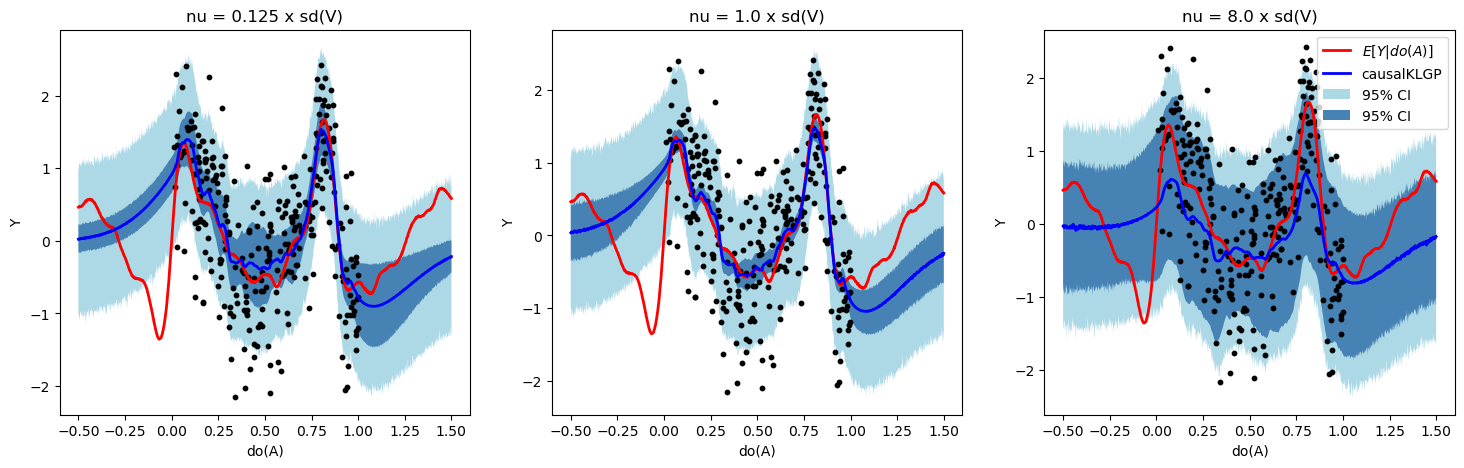

In [10]:
# Getting posterior samples and plotting results
power_list = torch.linspace(-3,3,3)
nulist = 2**power_list
features = 100
samples = 10**3
quantile = 0.95

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

Causalklgp_mu = []
Causalklgp_var = []
Causalklgp_var_noise = []

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model_nystrom)
    EYdoA_sample,YdoA_sample = causalklgp.nystrom_sample(Y,V,A,doA, reg = 1e-4, features = 100, samples = 10**3, nu = nulist[k])
    
    # Getting CI
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],EYdoA_sample.mean(0)[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],YdoA_sample.quantile(1-(1-quantile)/2,0),YdoA_sample.quantile((1-quantile)/2,0), color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],EYdoA_sample.quantile(1-(1-quantile)/2,0),EYdoA_sample.quantile((1-quantile)/2,0), color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    
    Causalklgp_mu.append(causalklgp_mu)
    Causalklgp_var.append(causalklgp_var.diag())
    Causalklgp_var_noise.append(causalklgp_var_noise.diag())

plt.legend()
plt.show()

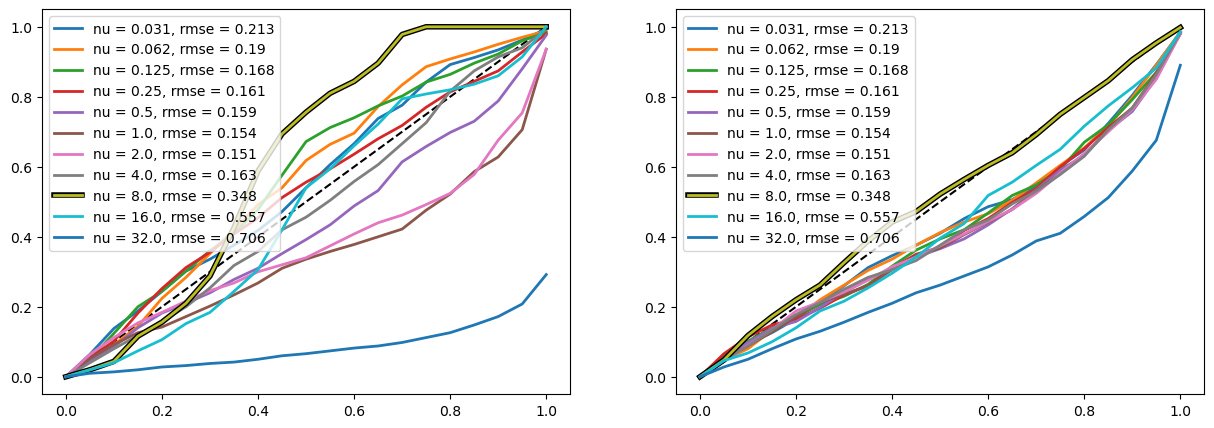

In [11]:
# Calibration plots
samples = 10**3
features = 100

outline=mpe.withStroke(linewidth=4, foreground='black')

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post samples
    EYdoA_sample, YdoA_sample = causalklgp.nystrom_sample(Y.reshape(train_samples,1),V,A,doA,reg = 1e-4, features = features, samples = samples,nu = nulist[k])
    upper_quantiles = 1-(1-levels)/2
    lower_quantiles = (1-levels)/2
    u = (upper_quantiles*(samples-1)).int()
    l = (lower_quantiles*(samples-1)).int()
    Y_u = YdoA_sample.sort(0)[0][u]
    Y_l = YdoA_sample.sort(0)[0][l]
    EY_u = EYdoA_sample.sort(0)[0][u]
    EY_l = EYdoA_sample.sort(0)[0][l]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EY_u[:,inds]>=EYdoA[inds,0])*(EY_l[:,inds]<=EYdoA[inds,0])).float().mean(1)    
    posterior_fraction_y = ((Y_u[:,inds]>=YdoA[inds])*(Y_l[:,inds]<=YdoA[inds])).float().mean(1)
    rmse = ((EYdoA[inds,0]-EYdoA_sample.mean(0)[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()